#CS146 Project 1: Linear regression and model comparison (LBA)

In [ ]:
#setting up the environment
!pip install pymc
!pip install arviz
!pip install aesara

In [ ]:
#setting up the environment
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd
import arviz as az

In [ ]:
#loading the data set

from google.colab import files
uploaded = files.upload()

Saving raw_fertility_rates_05to07.csv to raw_fertility_rates_05to07.csv


# Data Introduction

The data set that I am utilizing for the given assignment showcases the fertility rate of females in London in the age range between 15 and 49. The reason why I chose the given data is to analyze the potential relationship between these two indicators as it is an important topic regarding female health.

In [ ]:
# importing the data
df = pd.read_csv('raw_fertility_rates_05to07.csv')

df.columns

Index(['Code', 'Borough', 'Age 15 Fertility Rate', 'Age 16 Fertility Rate',
       'Age 17 Fertility Rate', 'Age 18 Fertility Rate',
       'Age 19 Fertility Rate', 'Age 20 Fertility Rate',
       'Age 21 Fertility Rate', 'Age 22 Fertility Rate',
       'Age 23 Fertility Rate', 'Age 24 Fertility Rate',
       'Age 25 Fertility Rate', 'Age 26 Fertility Rate',
       'Age 27 Fertility Rate', 'Age 28 Fertility Rate',
       'Age 29 Fertility Rate', 'Age 30 Fertility Rate',
       'Age 31 Fertility Rate', 'Age 32 Fertility Rate',
       'Age 33 Fertility Rate', 'Age 34 Fertility Rate',
       'Age 35 Fertility Rate', 'Age 36 Fertility Rate',
       'Age 37 Fertility Rate', 'Age 38 Fertility Rate',
       'Age 39 Fertility Rate', 'Age 40 Fertility Rate',
       'Age 41 Fertility Rate', 'Age 42 Fertility Rate',
       'Age 43 Fertility Rate', 'Age 44 Fertility Rate',
       'Age 45 Fertility Rate', 'Age 46 Fertility Rate',
       'Age 47 Fertility Rate', 'Age 48 Fertility Rate',
       'Age 

In [ ]:
# Converting the layout of the data from horizontal to vertical

# reshaping by specifying existing var columns and adding new Age coumns
df_long = pd.melt(df, id_vars=['Code', 'Borough'], var_name='Age', value_name='Fertility_Rate')

# extracting the number to represent age
df_long['Age'] = df_long['Age'].str.split(' ').str[1].astype(int)

# cleaning data by dropping unnecessary column
df_long = df_long.drop(columns = ['Code'])



In [ ]:
df_long

,Borough,Age,Fertility_Rate
0,Camden,15,0.006141
1,Kensington & Chelsea,15,0.005684
2,Westminster,15,0.004408
3,City of London & Hackney,15,0.003479
4,Hammersmith and Fulham,15,0.007457
...,...,...,...
1290,Central Boroughs,49,0.001342
1291,Rest of Inner Boroughs,49,0.001391
1292,Inner Boroughs,49,0.001415
1293,Outer Boroughs,49,0.000838


In [ ]:
df_long.columns

Index(['Borough', 'Age', 'Fertility_Rate'], dtype='object')

Because I am interested in overall fertility rate of London, I averaged out the fertility rates of all London boroughs to get one data point per every age.

In [ ]:
# Checking for missing data
missing_data = df_long.isnull().sum()
mean_count = df_long['Fertility_Rate'].mean()

# Displaying columns with missing data and their counts
print("Columns with Missing Data:")
print(missing_data[missing_data > 0])

Columns with Missing Data:
Series([], dtype: int64)


In [ ]:
# Calculate the average fertility rate for the whole city per age
af_df = df_long.groupby('Age')['Fertility_Rate'].mean().reset_index()

af_df

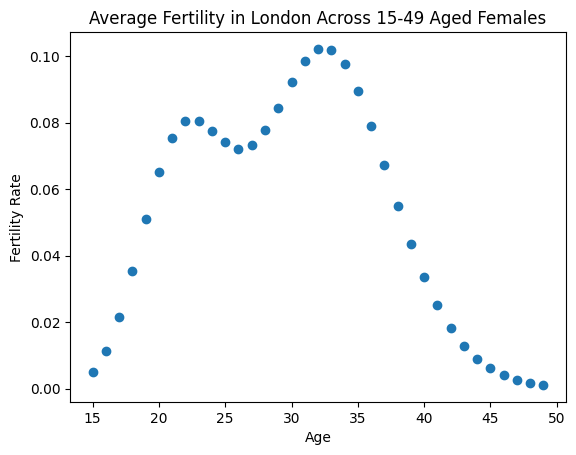

In [ ]:
plt.figure()
plt.scatter(af_df['Age'], af_df['Fertility_Rate'])
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
plt.title('Average Fertility in London Across 15-49 Aged Females')
plt.show()

##Normal Likelihood

In order to set up the model correctly, I followed the given steps:

1. **Priors Selection**: Started by defining priors for four coefficients (`c0`, `c1`, `c2`, `c3`) that are used in a cubic function. These coefficients contribute to determining the mean value. Specified a prior distribution for sigma, representing the standard deviation of our normal distribution.

2. **Cubic Function Choice**: I opted for a cubic function because of the typical trajectory observed in fertility rates across different age groups. It is known that at a younger age, individuals may have lower fertility rates due to various factors such as reproductive maturity. As individuals reach peak reproductive years, fertility rates tend to increase. However, fertility rates may decline due to biological factors or lifestyle changes. Therefore, I assumed that a cubic function can effectively capture this complex trajectory over age.

3. **Likelihood Specification**: The likelihood function establishes how well the model predicts the observed fertility rates given the ages.

6. **Model Evaluation**: Additionally, we set up our model to facilitate future comparisons with other models, as indicated by the comment "will be used for model comparison later". This enables us to evaluate the performance of this model against alternative approaches to better understand the relationship between age and fertility rate.

The first model is defined as below:

**Likelihood:**
$$ y_i {\space}{\sim}{\space} Normal({\mu}_{i}, {\sigma}^{2}) $$
$$ {\mu}_{i} = {c}_{0} + {c}_{1}{x}_{i} + {c}_{2}{{x}_{i}}^{2} + {c}_{3}{{x}_{i}}^{3}$$
**Prior:**
$${c}_{0} {\space}{\sim}{\space} Uniform(0, 1)$$
$${c}_{1} {\space}{\sim}{\space} Normal(0, 1)$$
$${c}_{2} {\space}{\sim}{\space} Normal(0, 1)$$
$${c}_{3} {\space}{\sim}{\space} Normal(0, 1)$$
$${\sigma} {\space}{\sim}{\space} Uniform(0, 0.5)$$

In [ ]:
data_x = np.array(af_df['Age'])
data_y = np.array(af_df['Fertility_Rate'])

In [ ]:
#setting up the model for one Nomral likelihood

with pm.Model() as m_1:
    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=1)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    c3 = pm.Normal('c3', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)
    # Data
    x = pm.MutableData('x', data_x)
    y = pm.MutableData('y', data_y)
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x + c2 * x**2 + c3*x**3)
    # Likelihood
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    #will be used for model comparison later


### Prior Predictive

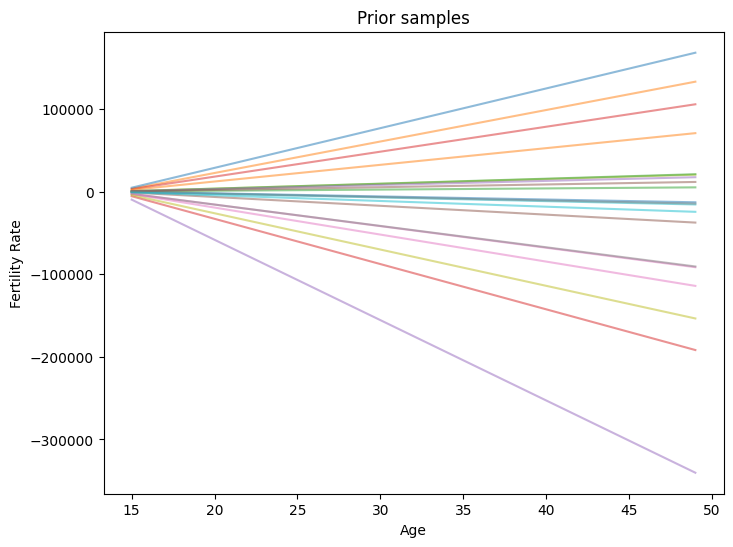

In [ ]:
#sampling from prior predictive for model 1

with m_1:
    inference_prior_predictive = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
plot_x = np.array([data_x.min(), data_x.max()])
plot_y = (
    inference_prior_predictive.prior.c0.values +
    plot_x.reshape(-1, 1) * inference_prior_predictive.prior.c1.values +
    inference_prior_predictive.prior.c2.values * plot_x.reshape(-1, 1)**2 +
    inference_prior_predictive.prior.c3.values * plot_x.reshape(-1, 1)**3)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

As depicted in the graph, we anticipat the data to cover a broad spectrum of values. This range is quite wide, ranging from nearly -40000 to 100000, which aligns with our expectation for the prior to encompass.

##Sampling

In [ ]:
with m_1:
    inference = pm.sample()

### Rank Plots, Summary, Trace Plots

array([[<Axes: title={'center': 'c0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'c3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

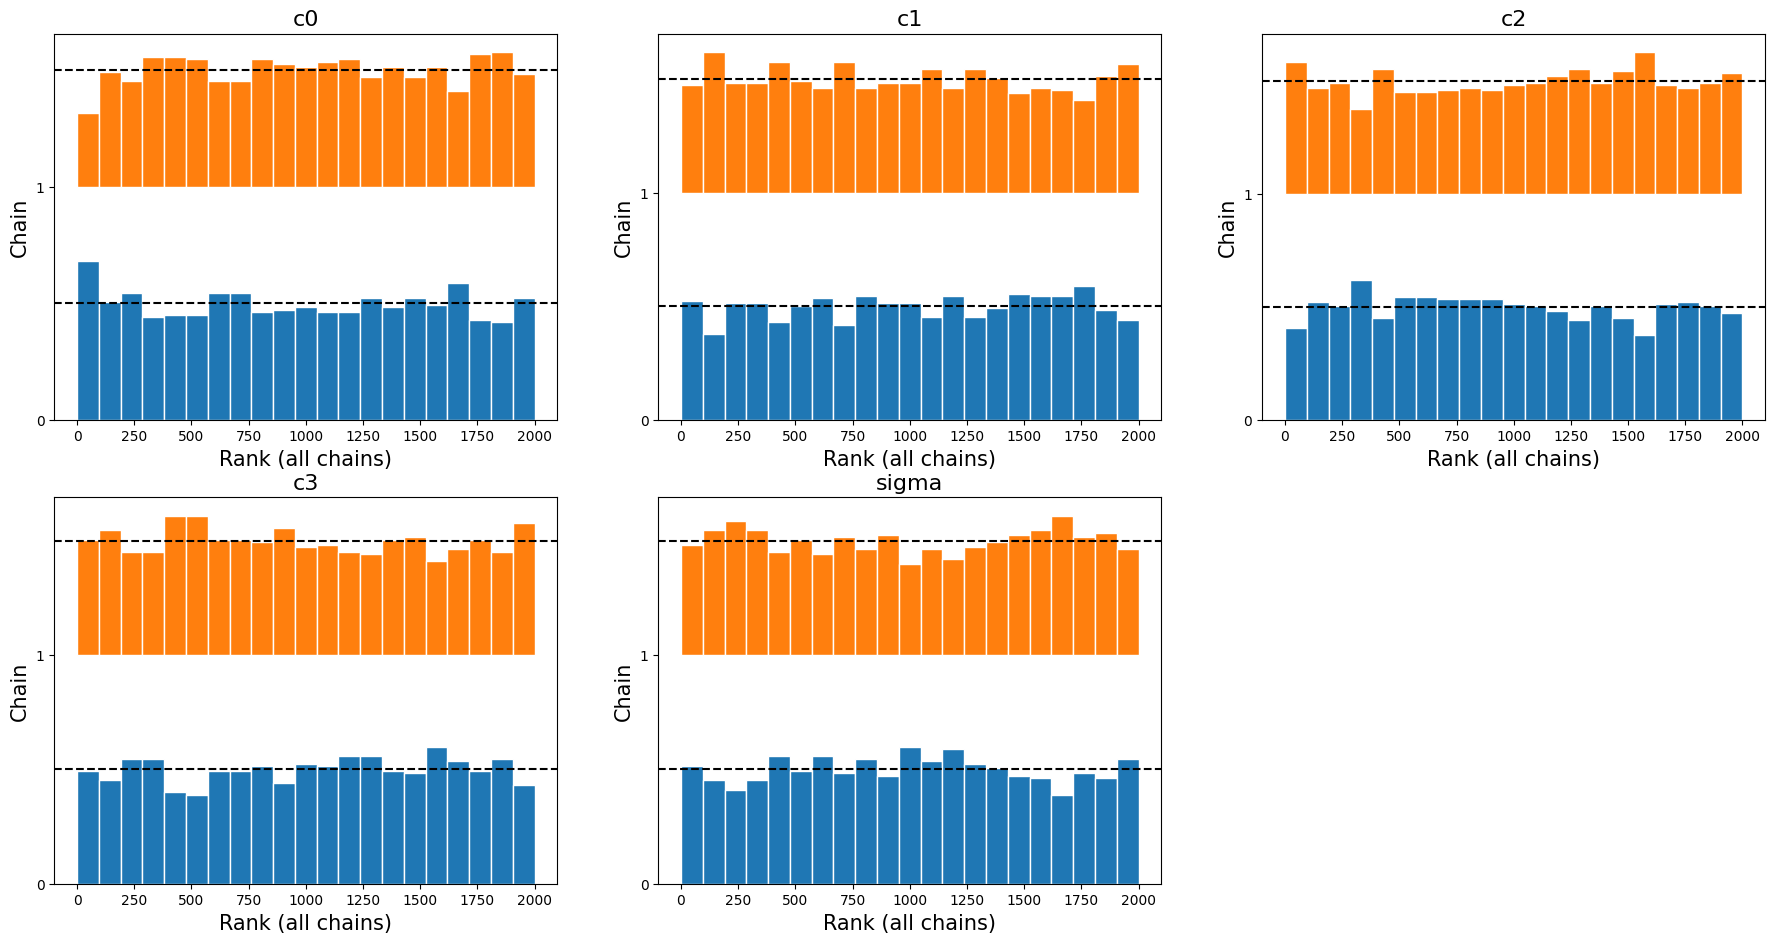

In [ ]:
az.plot_rank(inference, var_names=['c0', 'c1', 'c2', 'c3', 'sigma'])

The generated rank plot shows all the locations that MCMC visited given generated set of samples. We can observe that c1,c3, and sigma histograms are fairly uniform while c0 and c2 are slightly less uniform. But overall, all histograms suggest that algorithm was not stuck in any location. This ensures that the sampler works correctly.

In [ ]:
az.summary(inference, var_names=['c0', 'c1', 'c2', 'c3', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.026,0.028,0.000,0.080,0.002,0.001,367.0,445.0,1.0
c1,-0.003,0.003,-0.010,0.002,0.000,0.000,408.0,387.0,1.0
c2,0.000,0.000,0.000,0.001,0.000,0.000,414.0,376.0,1.0
c3,-0.000,0.000,-0.000,-0.000,0.000,0.000,443.0,429.0,1.0
sigma,0.019,0.003,0.015,0.024,0.000,0.000,757.0,802.0,1.0


The sumary table helps us identify if the sampling is accurate.

**Summary Table for all parameters**


***Mean***:
 - Our mean suggests the average value for our p for each parameter.

***SD***:
 - a low standard deviation for **p** implies more certainty in our estimates for c0,c1,c2,c3 sigma.

***R_Hat***: 1.0
- The value for R_Hat is exactly 1.0 for each parameter, indicating that the chains used in the sampling process successfully converged to the same distribution. Therefore, we can conclude that the varience of each chain is compared to variance between all chains, ensuring that they follow the same distribution.


***ESS_Bulk & ESS_Tail***
- Both ESS_Tail and ESS_Bulk are greater than 1/10th of the number of sample size. This indicates that there is no correlation between consecutive samples.

***MCSE_Mean & MCSE_SD***
- Both MCSE mean and SD are low for all parameters, indicating low numerical errors.



Overall, the summary table pensured us that the sampling is optimistic.


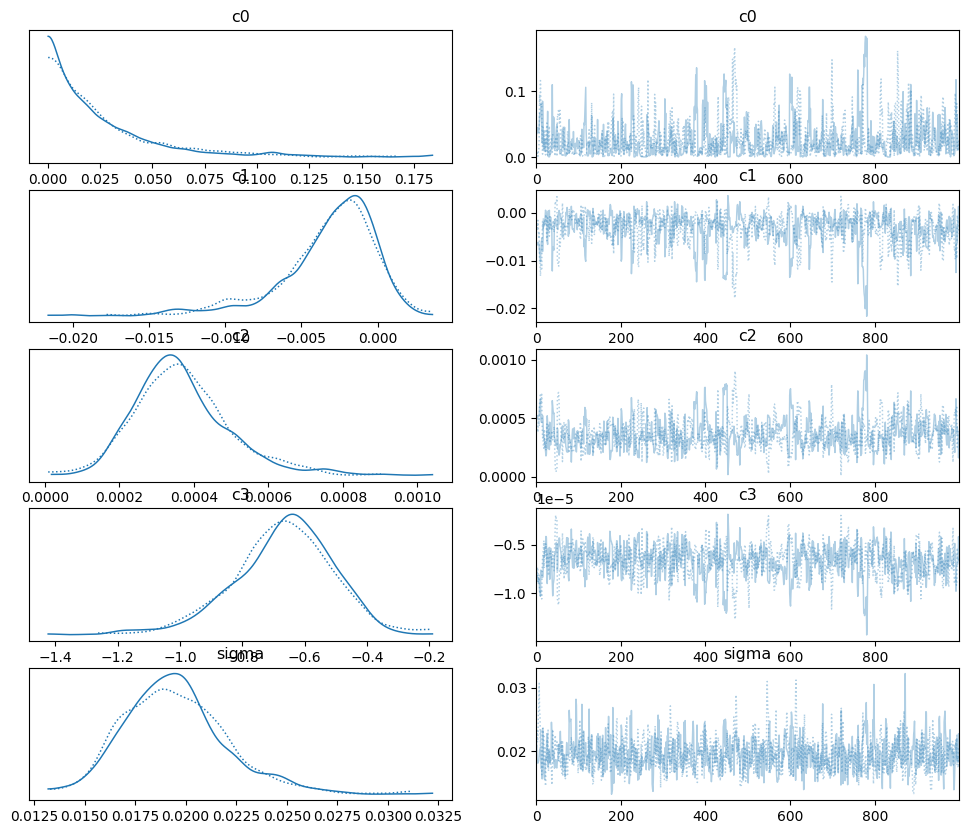

In [ ]:
az.plot_trace(inference, var_names=['c0', 'c1', 'c2', 'c3', 'sigma']);

Generating trace plots is another way to ensure that the sampler work correctly. All graphs on the right are according to main expectations that of observing a lot of noise rather than straight lines. We can also conclude that the sampler was taking constant steps and did not get stuck. Furthermore, the plots on the left show that the distributions from the samples continued to converge.

###Regression Line and Posterior & Posterior Predictive

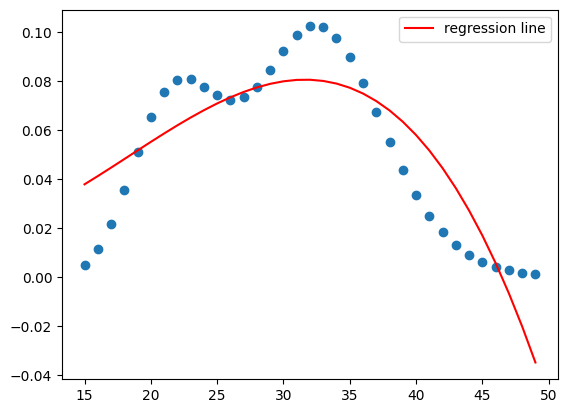

In [ ]:
#plotting the regression line

c0 = np.mean(inference.posterior.c0.values)
c1 = np.mean(inference.posterior.c1.values)
c2 = np.mean(inference.posterior.c2.values)
c3 = np.mean(inference.posterior.c3.values)
x = np.array(af_df['Age'])
plt.figure()
plt.scatter(af_df['Age'], af_df['Fertility_Rate'])
plt.plot(x, (c0 + c1*x + c2*x**2 + c3*x**3), color = 'red', label = 'regression line')
plt.legend()
plt.show()

The plot above showcases the regression line from our posterior distribution. Although the line does not fully capture the data line, it still seems to follow the overall trend of the data.

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


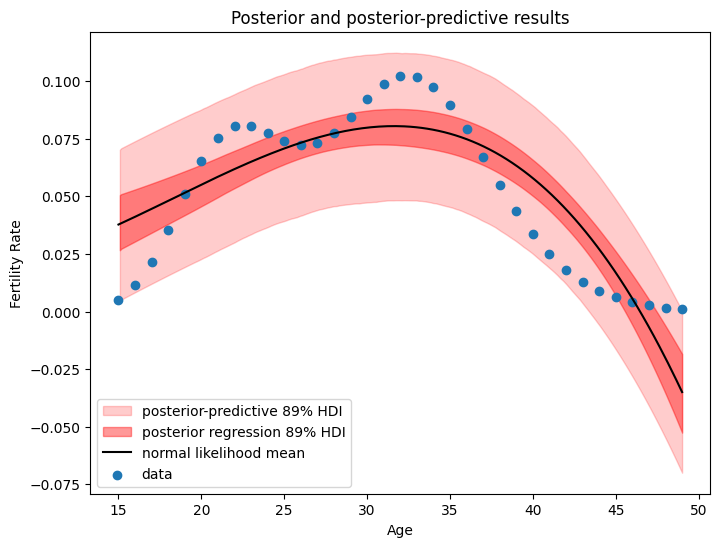

In [ ]:
# code adapted from Linear Regression notebook from session 7
posterior_samples_1 = inference.posterior.stack(
    sample=('chain', 'draw')).transpose('sample', ...)

plot_x = np.linspace(data_x.min(), data_x.max(), 200)
posterior_mu_1 = (
    posterior_samples_1.c0.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples_1.c1.values.reshape(1, -1) +
    posterior_samples_1.c2.values.reshape(1, -1) * plot_x.reshape(-1, 1)**2 +
    posterior_samples_1.c3.values.reshape(1, -1) * plot_x.reshape(-1, 1)**3)

posterior_y_1 = sts.norm.rvs(
    loc = posterior_mu_1,
    scale=posterior_samples_1.sigma.values.reshape(1, -1),
    size=posterior_mu_1.shape)

plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
ax = az.plot_hdi(plot_x, posterior_y_1.transpose(), hdi_prob=0.89, color='red', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu_1.transpose(), ax=ax, hdi_prob=0.89, color='red', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu_1.mean(axis=1), color='black', label='normal likelihood mean')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

This graph shows the data that our model predicts based on the posterior distribution. The solid black line in the middle is the mean regression line. The darker shaded region around it represents the 89% HDI interval for the regression values and the lighter shaded region represents the 89% interval for the predicted data. It seems that our model works well as it covers all of the data points within that interval. Although one might assume that the model overfits, we see that there are hardly any outliers.

##Sudent T Likelihood

The normal likelihood that was used above tends to have thin tails, which means it's less effective at accommodating outliers. To address this issue, we adjust the standard deviation and sometimes to the regression coefficients to fit the regression line to outlier data points better. However, since the chosen data set is small because I averaged out the fertility rates, the model can be sensitive to outliers and controls for them better.

The Student T distribution is a better alternative as it has heavier tails, which can be more sensitive to outliers. It includes a parameter (${ \nu }$) that determines the heaviness of these tails. Therefore, smaller values of ${ \nu }$ result in heavier tails, resembling distributions with more robust outlier handling, while larger values lead to tails resembling a normal distribution. This makes the Student T distribution particularly useful in cases where the presence of outliers needs to be addressed.

**Likelihood:**
$$ y_i {\space}{\sim}{\space} T({\nu}, {\mu}_{i}, {\sigma}) $$
$$ {\mu}_{i} = {c}_{0} + {c}_{1}{x}_{i} + {c}_{2}{{x}_{i}}^{2} + {c}_{3}{{x}_{i}}^{3}$$
**Prior:**
$${c}_{0} {\space}{\sim}{\space} Uniform(0, 5)$$
$${c}_{1} {\space}{\sim}{\space} Normal(0, 10)$$
$${c}_{2} {\space}{\sim}{\space} Normal(0, 10)$$
$${c}_{3} {\space}{\sim}{\space} Normal(0, 10)$$
$${\sigma} {\space}{\sim}{\space} Uniform(0, 10)$$
$${\nu} {\space}{\sim}{\space} Half-Normal({\sigma} = 30)$$

Below, is the application of Student T Model. Since all code cell will repeat the steps we utilized for the Normal likelihood model set up. Therefore, some explanation and wording will overlap with the first part



In [ ]:
#Setting up the model

with pm.Model() as m_2:
    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=0.5)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    c3 = pm.Normal('c3', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    nu = pm.HalfNormal('nu', sigma=30)
    # Data
    x = pm.MutableData('x', data_x)
    y = pm.MutableData('y', data_y)
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x + c2 * x **2 + c3 * x ** 3)
    # Likelihood
    pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)

### Prior predictive

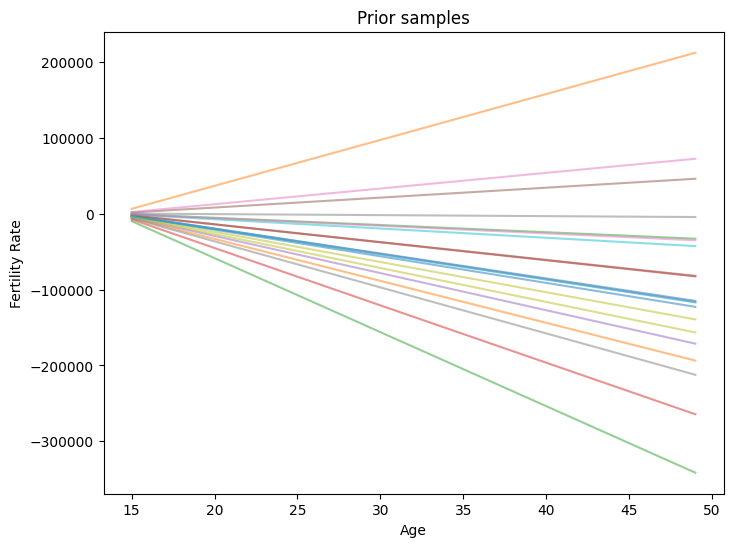

In [ ]:
with m_2:
    inference_prior_predictive = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
plot_x = np.array([data_x.min(), data_x.max()])
plot_y = (
    inference_prior_predictive.prior.c0.values +
    plot_x.reshape(-1, 1) * inference_prior_predictive.prior.c1.values +
    inference_prior_predictive.prior.c2.values * plot_x.reshape(-1, 1)**2 +
    inference_prior_predictive.prior.c3.values * plot_x.reshape(-1, 1)**3)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

The prior-predictive distribution shows that this model covers even a wider range which is not what we expect from Student T likelihood, signaling potential issues in samples.

### Sampling

In [ ]:
with m_2:
    inference_2 = pm.sample()

### Rank Plots, Summary, Trace Plots

array([[<Axes: title={'center': 'c0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'c3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

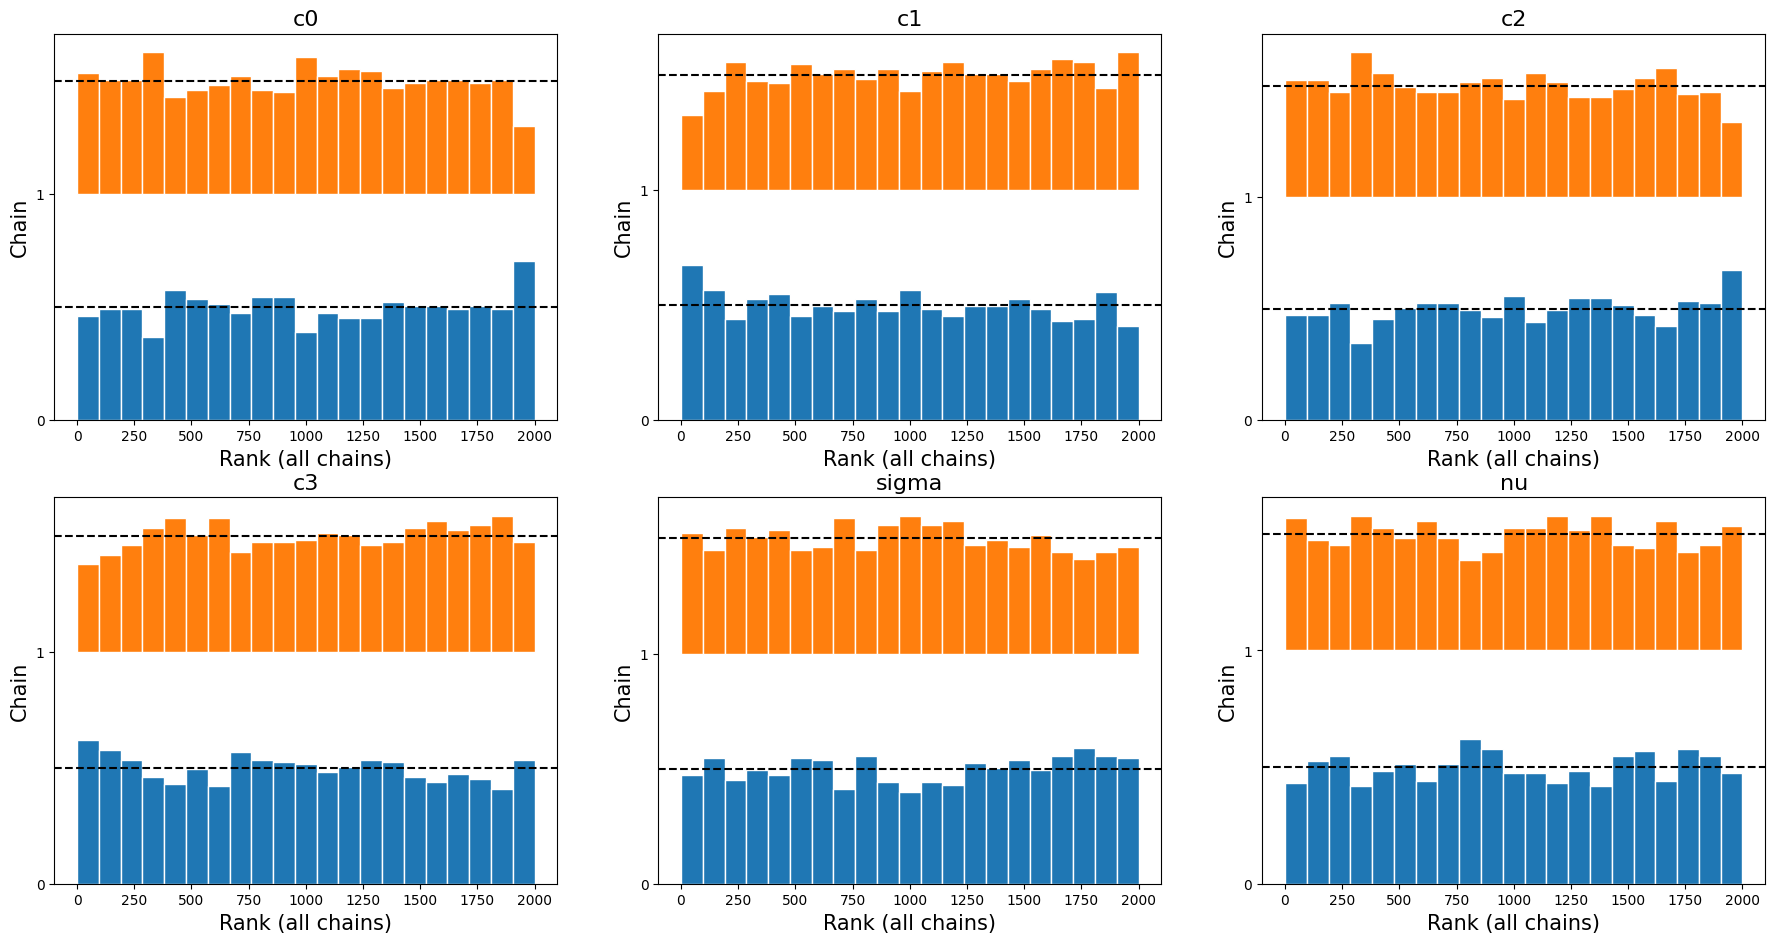

In [ ]:
az.plot_rank(inference_2, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'nu'])

The rank plots seem pretty uniform for all the variables; however, there is some variation compared to the first model.

In [ ]:
az.summary(inference_2, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.024,0.024,0.000,0.070,0.001,0.001,535.0,482.0,1.0
c1,-0.003,0.003,-0.009,0.002,0.000,0.000,537.0,557.0,1.0
c2,0.000,0.000,0.000,0.001,0.000,0.000,557.0,494.0,1.0
c3,-0.000,0.000,-0.000,-0.000,0.000,0.000,592.0,667.0,1.0
sigma,0.019,0.002,0.015,0.024,0.000,0.000,767.0,885.0,1.0
nu,29.729,17.398,3.286,61.320,0.527,0.373,883.0,667.0,1.0


The summary table helps us identify if the sampling is accurate.

Here too, we observe that the summary table showcases very satisfactory statistics.

**Summary Table for all parameters**


***Mean***:
 - Our mean suggests the average value for our p for each parameter.

***SD***:
 - a low standard deviation for **p** implies more certainty in our estimates for c0,c1,c2,c3, sigma, nu.

***R_Hat***: 1.0
- The value for R_Hat is exactly 1.0 for each parameter, indicating that the chains used in the sampling process successfully converged to the same distribution. Therefore, we can conclude that the varience of each chain is compared to variance between all chains, ensuring that they follow the same distribution.


***ESS_Bulk & ESS_Tail***
- Both ESS_Tail and ESS_Bulk are greater than 1/10th of the number of sample size. This indicates that there is no correlation between consecutive samples.

***MCSE_Mean & MCSE_SD***
- Both MCSE mean and SD are low for all parameters, indicating low numerical errors.




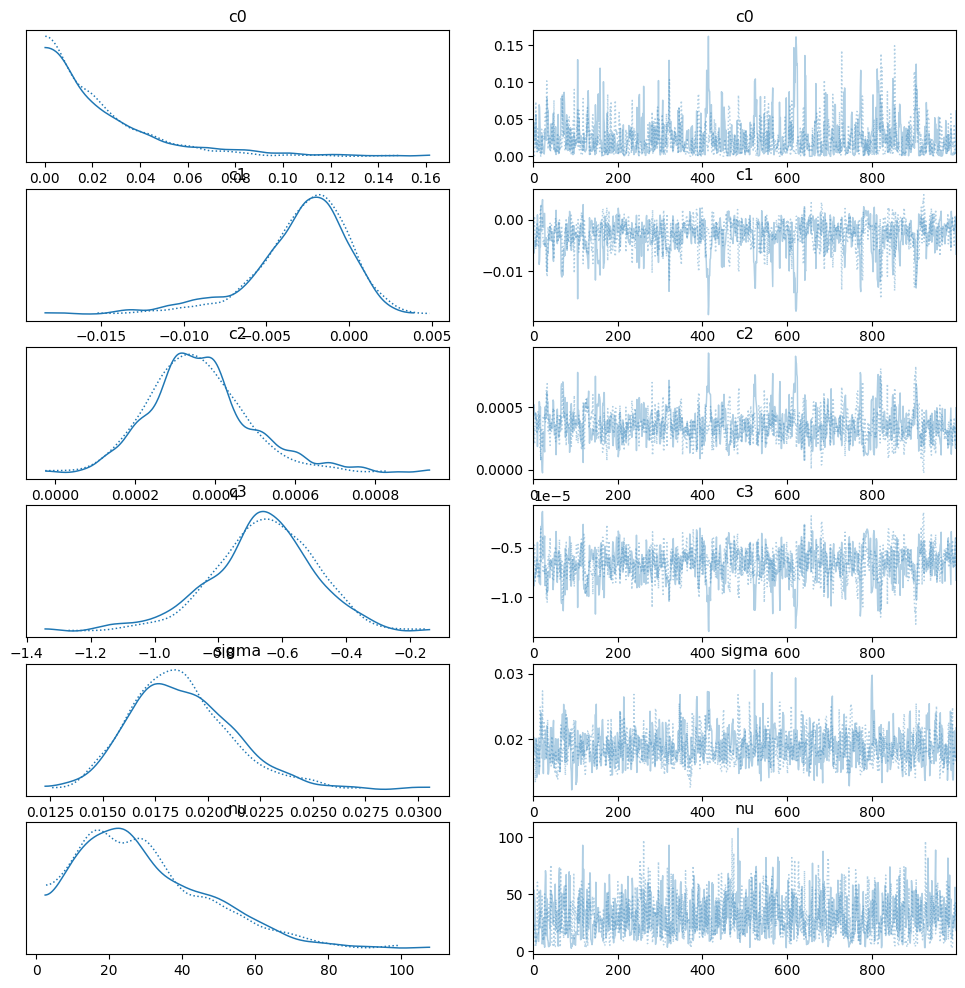

In [ ]:
az.plot_trace(inference_2, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'nu']);

Plots on both sides showcase satisfactory results with noise and convergence.

###Regression Line and Posterior & Posterior Predictive

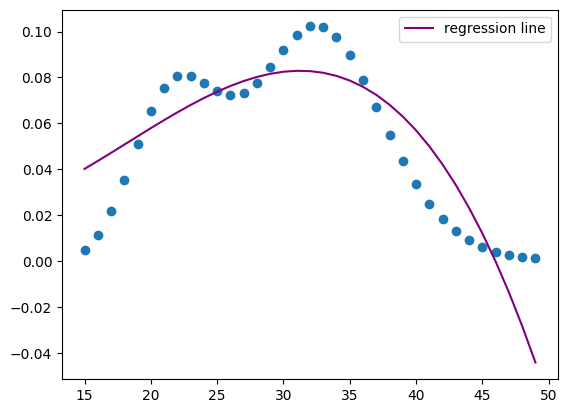

In [ ]:
c0 = np.mean(inference_2.posterior.c0.values)
c1 = np.mean(inference_2.posterior.c1.values)
c2 = np.mean(inference_2.posterior.c2.values)
c3 = np.mean(inference_2.posterior.c3.values)
x = np.array(af_df['Age'])
plt.figure()
plt.scatter(af_df['Age'], af_df['Fertility_Rate'])
plt.plot(x, (c0 + c1*x + c2*x**2 + c3*x**3), color = 'purple', label = 'regression line')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


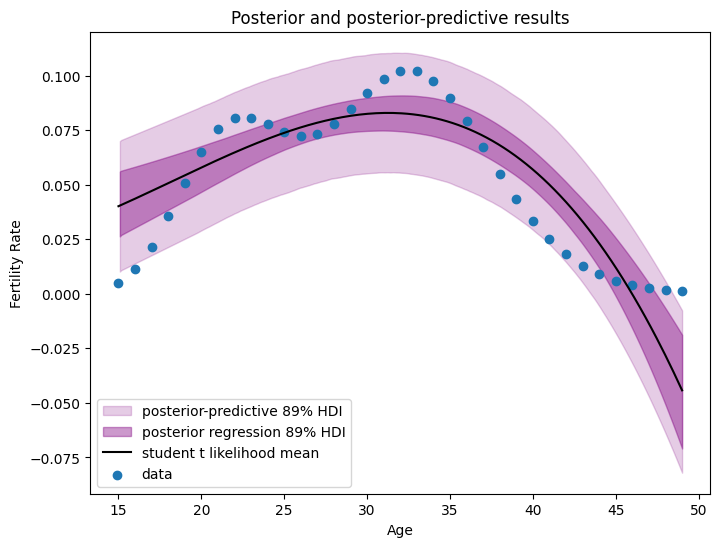

In [ ]:
posterior_samples_2 = inference_2.posterior.stack(
    sample=('chain', 'draw')).transpose('sample', ...)
plot_x = np.linspace(data_x.min(), data_x.max(), 200)
posterior_mu_2 = (
    posterior_samples_2.c0.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples_2.c1.values.reshape(1, -1) +
    posterior_samples_2.c2.values.reshape(1, -1) * plot_x.reshape(-1, 1)**2 +
    posterior_samples_2.c3.values.reshape(1, -1) * plot_x.reshape(-1, 1)**3)
posterior_y_2 = sts.norm.rvs(
    loc = posterior_mu_2,
    scale=posterior_samples_2.sigma.values.reshape(1, -1),
    size=posterior_mu_2.shape)
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
ax = az.plot_hdi(plot_x, posterior_y_2.transpose(), hdi_prob=0.89, color='purple', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu_2.transpose(), ax=ax, hdi_prob=0.89, color='purple', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu_2.mean(axis=1), color='black', label='student t likelihood mean')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

We are getting a slightly similar posterior-predictive distribution compared to the normal likelihood model with minimal differences. However, the lightly shaded region of 89% predicted data seems much narrower implying more precise prediction.

#Model comparison

In [ ]:
with m_1:
  inference_12 = pm.sample()
  pm.compute_log_likelihood(inference_12)
  pm.sample_posterior_predictive(inference_12, extend_inferencedata=True)

az.summary(inference_12, var_names=['c0', 'c1', 'c2', 'c3', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.025,0.024,0.000,0.071,0.001,0.001,420.0,541.0,1.00
c1,-0.003,0.003,-0.009,0.002,0.000,0.000,342.0,374.0,1.01
c2,0.000,0.000,0.000,0.001,0.000,0.000,330.0,304.0,1.00
c3,-0.000,0.000,-0.000,-0.000,0.000,0.000,358.0,309.0,1.00
sigma,0.019,0.003,0.015,0.024,0.000,0.000,893.0,985.0,1.00


Overall, the summary table is satisfactory. However, c1's R_hat seems to be on the upper range of the robustness, implying to potential less convergence of the samples. But this can also be accounted to chance.

In [ ]:
with m_2:
  inference_21 = pm.sample()
  pm.compute_log_likelihood(inference_21)
  pm.sample_posterior_predictive(inference_21, extend_inferencedata=True)

az.summary(inference_2, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.024,0.024,0.000,0.070,0.001,0.001,535.0,482.0,1.0
c1,-0.003,0.003,-0.009,0.002,0.000,0.000,537.0,557.0,1.0
c2,0.000,0.000,0.000,0.001,0.000,0.000,557.0,494.0,1.0
c3,-0.000,0.000,-0.000,-0.000,0.000,0.000,592.0,667.0,1.0
sigma,0.019,0.002,0.015,0.024,0.000,0.000,767.0,885.0,1.0
nu,29.729,17.398,3.286,61.320,0.527,0.373,883.0,667.0,1.0


Overall, this summary table is satisfactory too. The fact that all R-hats are exactly 1.0, implies better sampling of the model compared to Normal Likelihood.

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


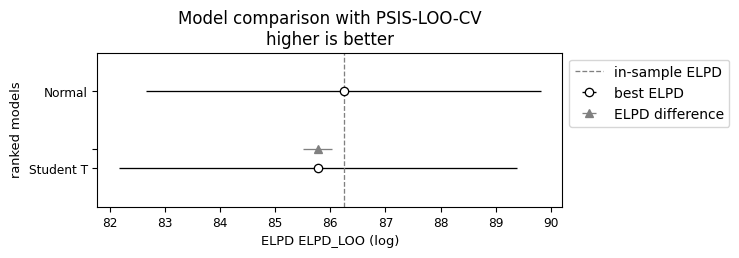

In [ ]:
inferences = {'Normal': inference_12, 'Student T': inference_21}
df_inf = az.compare(inferences, ic='loo')
az.plot_compare(df_inf)
plt.title('Model comparison with PSIS-LOO-CV\nhigher is better')
plt.xlabel('ELPD ' + df_inf.columns[1].upper() + ' (log)')
plt.legend(['in-sample ELPD', 'best ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In my understanding, PSIS-LOO CV is a technique that is used to estimate the out-of-sample predictive performance of a model. It evaluates how well the model predicts unseen data points by repeatedly leaving out one observation at a time and computing the log-likelihood for the left-out point given the rest of the data.

Given the graph, we can see that the best ELPD for Normal Likelihood is slightly above 86 while the best ELPD for Student T is slightly below 86. This suggests that the Normal Likelihood model performs slightly better in terms of predictive accuracy compared to the Student T model. The difference in ELPD between the two models is relatively small, indicating that the Normal Likelihood model has a slight advantage in capturing the underlying patterns in the data and making predictions.